# Best Representation Vectors - Summarize an entire book
In the above method we pass the entire document (all 9.5K tokens of it) to the LLM. But what if you have more tokens than that?

What if you had a book you wanted to summarize? Let's load one up, we're going to load [Into Thin Air](https://www.amazon.com/Into-Thin-Air-Personal-Disaster/dp/0385494785) about the 1996 Everest Disaster

In [1]:
import langchain
langchain.__version__

'0.0.350'

In [17]:
from dotenv import load_dotenv
import os

load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY")
openai_organization = os.getenv("OPEN_AI_ORG")

from langchain_openai import OpenAI
llm = OpenAI(
    temperature=0, 
    openai_api_key=openai_api_key,
    openai_organization = openai_organization
)

I'm going to initialize two models, gpt-3.5 and gpt4. I'll use gpt 3.5 for the first set of summaries to reduce cost and then gpt4 for the final pass which should hopefully increase the quality.

In [5]:
# Loaders
from langchain.schema import Document
# Splitters
from langchain.text_splitter import RecursiveCharacterTextSplitter
# Model
from langchain_openai import ChatOpenAI
# Embedding Support
from langchain.vectorstores import FAISS
from langchain_openai.embeddings import OpenAIEmbeddings
# Summarizer we'll use for Map Reduce
from langchain.chains.summarize import load_summarize_chain
# Data Science
import numpy as np
from sklearn.cluster import KMeans

from langchain import PromptTemplate
import os

In [ ]:
from langchain.document_loaders import PyPDFLoader

# Load the book
loader = PyPDFLoader("./data/IntoThinAirBook.pdf")
pages = loader.load()

In [42]:
len(pages)

282

In [43]:
# Cut out the open and closing parts
pages = pages[26:277]

# Combine the pages, and replace the tabs with spaces
text = ""

for page in pages:
    text += page.page_content
    
text = text.replace('\t', ' ')

In [44]:
len(pages)

251

Now our book is split up into 78 documents
Let's get our embeddings of those 78 documents

In [10]:
num_tokens = llm.get_num_tokens(text)
print (f"This book has {num_tokens} tokens in it")

This book has 131710 tokens in it


This book has 139472 tokens in it
Wow, that's over 100K tokens, even [GPT 32K](https://help.openai.com/en/articles/7127966-what-is-the-difference-between-the-gpt-4-models) wouldn't be able to handle that in one go. At [0.03 per 1K prompt tokens](https://help.openai.com/en/articles/7127956-how-much-does-gpt-4-cost), this would cost us $4.17 just for the prompt alone.

So how do we do this without going through all the tokens? Pick random chunks? Pick equally spaced chunks?

I kicked off a [twitter thread](https://twitter.com/GregKamradt/status/1653060004226924544) with a proposed solution to see if I was off base. I'm calling it the Best Representation Vectors method (not sure if a name already exists for it).

Goal: Chunk your book then get embeddings of the chunks. Pick a subset of chunks which represent a wholistic but diverse view of the book. Or another way, is there a way to pick the top 10 passages that describe the book the best?

Once we have our chunks that represent the book then we can summarize those chunks and hopefully get a pretty good summary.

Keep in mind there are tools that would likely do this for you, and with token limits increasing this won't be a problem for long. But if you want to do it from scratch this might help.

This is most definitely not the optimal answer, but it's my take on it for now! If the [clustering](https://scikit-learn.org/stable/modules/clustering.html) experts wanna help improve it that would be awesome.

**The BRV Steps:**

1. Load your book into a single text file
2. Split your text into large-ish chunks
3. Embed your chunks to get vectors
4. Cluster the vectors to see which are similar to each other and likely talk about the same parts of the book
5. Pick embeddings that represent the cluster the most (method: closest to each cluster centroid)
6. Summarize the documents that these embeddings represent
7. Another way to phrase this process, "Which ~10 documents from this book represent most of the meaning? I want to build a summary off those."

Note: There will be a bit of information loss, but show me a summary of a whole book that doesn't have information loss ;)

In [7]:
text_splitter = RecursiveCharacterTextSplitter(separators=["\n\n", "\n", "\t"], chunk_size=10000, chunk_overlap=3000)
docs = text_splitter.create_documents([text])

In [8]:
num_documents = len(docs)
print (f"Now our book is split up into {num_documents} documents")

Now our book is split up into 78 documents


In [18]:
embeddings = OpenAIEmbeddings(
    openai_api_key=openai_api_key,
    openai_organization = openai_organization
)
vectors = embeddings.embed_documents([x.page_content for x in docs])

Now let's cluster our embeddings. There are a ton of clustering algorithms you can chose from. Please try a few out to see what works best for you!

In [19]:
# Assuming 'embeddings' is a list or array of 1536-dimensional embeddings

# Choose the number of clusters, this can be adjusted based on the book's content.
# I played around and found ~10 was the best.
# Usually if you have 10 passages from a book you can tell what it's about
num_clusters = 11

# Perform K-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42).fit(vectors)

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [20]:
kmeans.labels_

array([ 0,  0,  0,  0,  0,  0,  1,  1,  0,  0,  0,  1,  8,  1,  1,  1,  1,
        8,  8,  8,  8,  1,  1,  9,  8,  3,  3,  3,  9,  9,  1,  1,  1,  4,
        3,  1,  4,  4,  4,  4,  4,  4,  2,  4,  4,  4,  5,  4,  5,  2,  5,
        5,  5,  2,  2,  2,  2,  2,  2,  4,  5,  4,  4,  4,  1,  1,  1,  1,
        1,  1, 10, 10, 10,  7,  7,  7,  6,  6], dtype=int32)

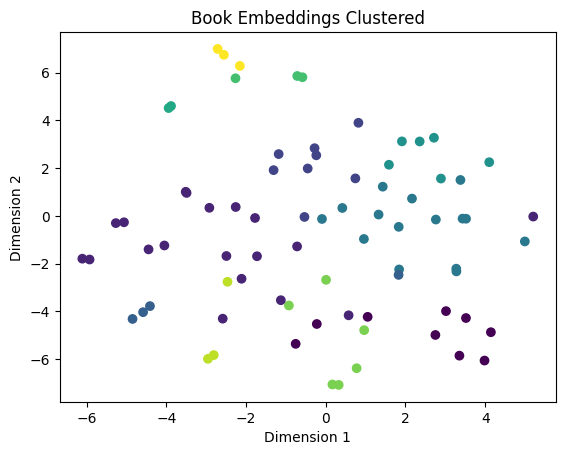

In [25]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Taking out the warnings
import warnings
from warnings import simplefilter

# Filter out FutureWarnings
simplefilter(action='ignore', category=FutureWarning)

# Perform t-SNE and reduce to 2 dimensions
tsne = TSNE(n_components=2, random_state=42)
reduced_data_tsne = tsne.fit_transform(np.array(vectors))

# Plot the reduced data
plt.scatter(reduced_data_tsne[:, 0], reduced_data_tsne[:, 1], c=kmeans.labels_)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Book Embeddings Clustered')
plt.show()

Awesome, not perfect, but pretty good directionally. Now we need to get the vectors which are closest to the cluster centroids (the center).

The function below is a quick way to do that (w/ help from ChatGPT)

In [26]:
# Find the closest embeddings to the centroids

# Create an empty list that will hold your closest points
closest_indices = []

# Loop through the number of clusters you have
for i in range(num_clusters):
    
    # Get the list of distances from that particular cluster center
    distances = np.linalg.norm(vectors - kmeans.cluster_centers_[i], axis=1)
    
    # Find the list position of the closest one (using argmin to find the smallest distance)
    closest_index = np.argmin(distances)
    
    # Append that position to your closest indices list
    closest_indices.append(closest_index)

Now sort them (so the chunks are processed in order)

In [27]:
selected_indices = sorted(closest_indices)
selected_indices

[5, 12, 26, 28, 39, 51, 56, 65, 71, 74, 76]

It's intersting to see which chunks pop up at most descriptive. How does your distribution look?

Let's create our custom prompts. I'm going to use gpt4 (which has a bigger token limit) for the combine step so I'm asking for long summaries in the map step to reduce the information loss.

In [28]:
llm3 = ChatOpenAI(
    temperature=0,
    openai_api_key=openai_api_key,
    openai_organization = openai_organization,
    max_tokens=1000,
    model='gpt-3.5-turbo'
)

In [29]:
map_prompt = """
You will be given a single passage of a book. This section will be enclosed in triple backticks (```)
Your goal is to give a summary of this section so that a reader will have a full understanding of what happened.
Your response should be at least three paragraphs and fully encompass what was said in the passage.

```{text}```
FULL SUMMARY:
"""
map_prompt_template = PromptTemplate(template=map_prompt, input_variables=["text"])

I kept getting a timeout errors so I'm actually going to do this map reduce manually

In [30]:
map_chain = load_summarize_chain(
    llm=llm3,
    chain_type="stuff",
    prompt=map_prompt_template)

Then go get your docs which the top vectors represented.

In [39]:
selected_docs = [docs[doc] for doc in selected_indices]
len(selected_docs)

11

Let's loop through our selected docs and get a good summary for each chunk. We'll store the summary in a list.

In [32]:
# Make an empty list to hold your summaries
summary_list = []

# Loop through a range of the lenght of your selected docs
for i, doc in enumerate(selected_docs):
    
    # Go get a summary of the chunk
    chunk_summary = map_chain.run([doc])
    
    # Append that summary to your list
    summary_list.append(chunk_summary)
    
    print (f"Summary #{i} (chunk #{selected_indices[i]}) - Preview: {chunk_summary[:250]} \n")

Summary #0 (chunk #5) - Preview: In this passage, the narrator reflects on his past climbing experiences and his current life situation. He recounts his previous challenging climbs, including scaling the Devils Thumb and Cerro Torre, but acknowledges that these were done when he was 

Summary #1 (chunk #12) - Preview: In this passage, the author describes the dangerous conditions and treacherous terrain of Mount Everest. They mention how the altitude is too high for safe evacuation by helicopter, so Tenzing, who had fallen into a crevasse, would have to be carried 

Summary #2 (chunk #26) - Preview: In this passage, the author recounts the events surrounding the illness and rescue of a Sherpa named Ngawang on Mount Everest. Ngawang had been feeling weak and short of breath for several days but ignored instructions to descend to Base Camp and ins 

Summary #3 (chunk #28) - Preview: This passage provides information about the use of the internet at Everest Base Camp during a climbing exp

Great, now that we have our list of summaries, let's get a summary of the summaries

In [33]:
summaries = "\n".join(summary_list)

# Convert it back to a document
summaries = Document(page_content=summaries)

print (f"Your total summary has {llm.get_num_tokens(summaries.page_content)} tokens")

Your total summary has 3706 tokens


In [34]:
llm4 = ChatOpenAI(
    temperature=0,
    openai_api_key=openai_api_key,
    openai_organization = openai_organization,
    max_tokens=3000,
    model='gpt-4',
    request_timeout=120)

In [35]:
combine_prompt = """
You will be given a series of summaries from a book. The summaries will be enclosed in triple backticks (```)
Your goal is to give a verbose summary of what happened in the story.
The reader should be able to grasp what happened in the book.

```{text}```
VERBOSE SUMMARY:
"""
combine_prompt_template = PromptTemplate(template=combine_prompt, input_variables=["text"])

In [36]:
reduce_chain = load_summarize_chain(
    llm=llm4,
    chain_type="stuff",
    prompt=combine_prompt_template,
    verbose=True # Set this to true if you want to see the inner workings
)

In [37]:
output = reduce_chain.run([summaries])



> Entering new StuffDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:

You will be given a series of summaries from a book. The summaries will be enclosed in triple backticks (```)
Your goal is to give a verbose summary of what happened in the story.
The reader should be able to grasp what happened in the book.

```In this passage, the narrator reflects on his past climbing experiences and his current life situation. He recounts his previous challenging climbs, including scaling the Devils Thumb and Cerro Torre, but acknowledges that these were done when he was younger and in his prime. He is now married, has a stable career, and is content with his life. However, despite the risks and dangers associated with climbing Everest, the narrator's childhood dream of climbing the mountain resurfaces, and he eagerly accepts an invitation to join Rob Hall's expedition.

The passage then transitions to the narrator's journey to Kathmandu, where he catches a gl

In [40]:
print(output)

The story begins with the narrator reflecting on his past climbing experiences and his current life situation. He recalls his previous challenging climbs, including scaling the Devils Thumb and Cerro Torre, but acknowledges that these were done when he was younger and in his prime. Now, he is married, has a stable career, and is content with his life. However, his childhood dream of climbing Everest resurfaces, and he eagerly accepts an invitation to join Rob Hall's expedition. The narrator then travels to Kathmandu, where he catches a glimpse of the Himalayas from the airplane. He is in awe of the mountains, particularly Everest, and feels a sense of trepidation about his decision to climb to its summit. Upon arrival, he meets Andy Harris, one of Hall's guides, and they discuss their climbing experiences. The narrator also meets Lou Kasischke, another client on the expedition. They are all staying at the Garuda Hotel, a popular choice for climbers, and the walls are adorned with photo